# Exploratory Data Analysis of Epicurious Scrape in a JSON file

This is an idealized workflow for Aaron Chen in looking at data science problems. It likely isn't the best path, nor has he rigidly applied or stuck to this ideal, but he wishes that he worked this way more frequently.

## Purpose: This notebook will do some clustering and classification on the recipes missing cuisine labels. Make this fast and see what we can get. Then move on to:

1. Fixing Render
2. Creating login system to store searches and preferences
3. Fixing the filtering
4. Working on scrapers
5. Working on the database

### Author: Aaron Chen


---

### If needed, run shell commands here

In [1]:
# !python -m spacy download en_core_web_sm
# !python -c "import tkinter"

---

## External Resources

List out references or documentation that has helped you with this notebook

### Code
Regex Checker: https://regex101.com/

#### Scikit-learn
1. https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda
2. 

### Data

For this notebook, the data is stored in the repo base folder/data/raw

### Process

Are there steps or tutorials you are following? Those are things I try to list in Process

___

## Import necessary libraries

In [1]:
# from bokeh.plotting import figure, output_file, save, show
# from bokeh.io import output_notebook
import hdbscan
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import optuna
import pandas as pd
from scipy.spatial.distance import euclidean
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split


---

## Define helper functions

My workflow is to try things with code cells, then when the code cells get messy and repetitive, to convert into helper functions that can be called.

When the helper functions are getting used a lot, it is usually better to convert them to scripts or classes that can be called/instantiated

### Import local script

I started grouping this in with importing libraries, but putting them at the bottom of the list

In [2]:
import project_path

import src.dataframe_preprocessor as dfpp
import src.nlp_processor as nlp_proc
import src.plotter as ILoveMyKeyboard
import src.transformers as skt

%matplotlib inline

/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


---

## Define global variables 
### Remember to refactor these out, not ideal

In [ ]:
# output_notebook()

---

## Running Commentary

1. 

### To Do

1. 

---

## Importing and viewing the data as a dataframe

In [3]:
raw_data_path = '../../data/recipes-en-201706/epicurious-recipes_m2.json'

joblib_basepath = '../../joblib/2022.08.23/'

cv_path = joblib_basepath + 'countvec.joblib'
tfidf_path = joblib_basepath + 'tfidf.joblib'
full_df_path = joblib_basepath + 'recipes_with_cv.joblib'
reduced_df_path = joblib_basepath + 'reduced_df.joblib'
rfc_path = joblib_basepath + 'rfc_clf.joblib'
X_path = joblib_basepath + 'X.joblib'
y_path = joblib_basepath + 'y.joblib'
truncSVD_path = joblib_basepath + 'truncSVD.joblib'
truncSVD_transformed_path = joblib_basepath + 'truncSVD_transformed.joblib'
svd_numpy_path = joblib_basepath + 'SVD_numpy.joblib'
to_plot_path = joblib_basepath + 'to_plot.joblib'
tsne_path = joblib_basepath + 'tsne.joblib'
tsne_vis_path = joblib_basepath + 'tsne_vis.joblib'
kmeans_path = joblib_basepath + 'kmeans.joblib'

Let's get Optuna working with HDBSCAN and DBCV.

Seems like the idea is to maximize the DBCV score.

In [4]:
cv = load(cv_path)
tfidf = load(tfidf_path)
recipes_with_cv = load(full_df_path)
recipes_with_cv.set_index('id', inplace=True, drop=True)
reduced_df = load(reduced_df_path)
reduced_df.set_index('id', inplace=True, drop=True)
rfc_clf = load(rfc_path)
X = load(X_path)
y = load(y_path)

In [5]:
y

id
54a408a019925f464b3733bc     Italian
54a408a26529d92b2c003631      Kosher
54a408a66529d92b2c003638      Kosher
54a408a719925f464b3733cc      Kosher
54a408c36529d92b2c0036a1      French
                              ...   
587fabfecd2508314395ad8c     Chinese
588a417612082e6b03c03d27      Indian
58924da769cf1107794eb164    American
594006de68bd4e58aaab1d26       Asian
5952cdea109c972493636f7c    Japanese
Name: cuisine_name, Length: 14832, dtype: object

In [ ]:
recipes_with_cv

In [6]:
X_train, X_test, y_train, y_test, indices_train, indices_test,  = train_test_split(
        X, y, X.index, random_state=240, stratify=y
    )

In [7]:
X_train

,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a45bfb6529d92b2c023f25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a4638719925f464b395c16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a441126529d92b2c01b5f2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a409bb19925f464b37380a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a42e1019925f464b3818d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54a436266529d92b2c018767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a466e16529d92b2c026f67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a451cd6529d92b2c01eefd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
indices_train

Index(['54a45bfb6529d92b2c023f25', '54a4638719925f464b395c16',
       '54a441126529d92b2c01b5f2', '54a409bb19925f464b37380a',
       '54a42e1019925f464b3818d4', '54a4555f19925f464b391364',
       '54a43aa66529d92b2c019e9f', '54a455ea19925f464b391a6e',
       '54a4577b19925f464b392619', '54a4530e19925f464b38f4d1',
       ...
       '54a479e719925f464b39b2ff', '54a431ae19925f464b384549',
       '54a453c319925f464b38feaf', '54a4091819925f464b37358c',
       '54a434ef6529d92b2c017765', '54a436266529d92b2c018767',
       '54a466e16529d92b2c026f67', '54a451cd6529d92b2c01eefd',
       '54a44e026529d92b2c01d6dd', '54a45aa06529d92b2c02364f'],
      dtype='object', name='id', length=11124)

### Defining our trial (Optuna)

In [ ]:
# def objective(trial):
#     cluster_size = trial.suggest_int('min_cluster_size', 10, 200)
#     min_samps = trial.suggest_int('min_samples', 5, 60)
#     cluster_selection_eps = trial.suggest_float('cluster_selection_epsilon', 0.2, 0.7)

#     hdbscanner = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=min_samps, cluster_selection_epsilon=cluster_selection_eps)

#     hdbscan_labels = hdbscanner.fit_predict(X_train.values)

#     # DBCV is actually built into HDBSCAN but in the validity class
#     # remember this score is from -1 to 1
#     hdbscan_score = hdbscan.validity.validity_index(X_train.values, hdbscan_labels, metric='euclidean')
#     #hdbscan_score = DBCV(X_train.values, hdbscan_labels, dist_function=euclidean)
    
#     return hdbscan_score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000) #, gc_after_trial=True)
# print(study.best_trial)

### Based on docs, it sounds like I have to make a new objective with Optuna that calls hdbscan.prediction with best_trial as an argument

Actually take this back:

We're going to do dimension reduction like we should have to begin with...

In [9]:
from sklearn.decomposition import NMF

In [10]:
X_nmf= nmf = NMF(
    n_components=10,
    random_state=1,
    init='nndsvd',
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit_transform(X)

In [12]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 10
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'components_'

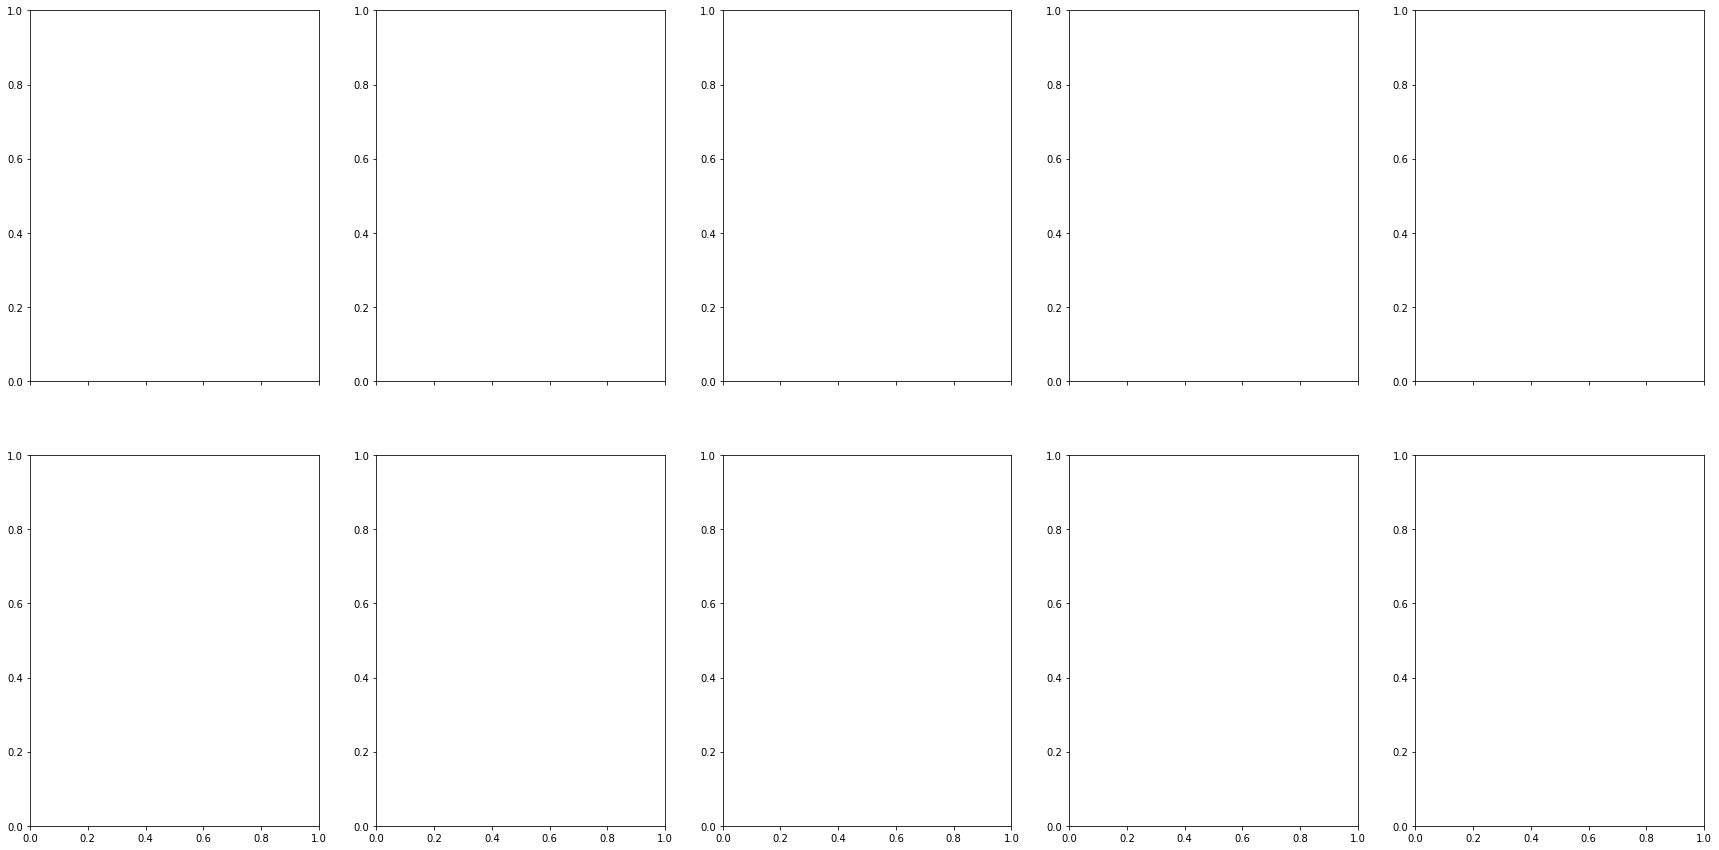

In [13]:
tfidf_feature_names = cv.get_feature_names_out()
plot_top_words(
    tfidf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [14]:
X_nmf_df = pd.DataFrame(data=X_nmf, index=X.index)

In [19]:
X_nmf_train, X_nmf_test, y_train, y_test, nmf_train_indices, nmf_test_indices = train_test_split(
        X_nmf_df, y, X_nmf_df.index, random_state=240, stratify=y
    )

In [20]:
X_train

,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a45bfb6529d92b2c023f25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a4638719925f464b395c16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a441126529d92b2c01b5f2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a409bb19925f464b37380a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a42e1019925f464b3818d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54a436266529d92b2c018767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a466e16529d92b2c026f67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a451cd6529d92b2c01eefd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print(X_nmf_train)

                                 0         1         2         3         4  \
id                                                                           
54a45bfb6529d92b2c023f25  0.011332  0.000000  0.000000  0.000000  0.024039   
54a4638719925f464b395c16  0.002359  0.030674  0.000000  0.000000  0.000000   
54a441126529d92b2c01b5f2  0.009284  0.000000  0.000000  0.000000  0.021213   
54a409bb19925f464b37380a  0.018171  0.009565  0.000000  0.076212  0.000000   
54a42e1019925f464b3818d4  0.024393  0.005658  0.019932  0.000000  0.005299   
...                            ...       ...       ...       ...       ...   
54a436266529d92b2c018767  0.000000  0.034086  0.000000  0.000000  0.000000   
54a466e16529d92b2c026f67  0.013393  0.000000  0.000000  0.000000  0.000000   
54a451cd6529d92b2c01eefd  0.011930  0.000000  0.000000  0.058731  0.000000   
54a44e026529d92b2c01d6dd  0.000000  0.058866  0.000000  0.000000  0.000000   
54a45aa06529d92b2c02364f  0.000000  0.058318  0.000000  0.000000

In [23]:
def objective(trial):
    cluster_size = trial.suggest_int('min_cluster_size', 10, 200)
    min_samps = trial.suggest_int('min_samples', 5, 60)
    cluster_selection_eps = trial.suggest_float('cluster_selection_epsilon', 0.2, 0.7)

    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=min_samps, cluster_selection_epsilon=cluster_selection_eps, prediction_data=True)

    hdbscan_labels = hdbscanner.fit_predict(X_nmf_train.values)

    # DBCV is actually built into HDBSCAN but in the validity class
    # remember this score is from -1 to 1
    hdbscan_score = hdbscan.validity.validity_index(X_nmf_train.values, hdbscan_labels, metric='euclidean')
    #hdbscan_score = DBCV(X_train.values, hdbscan_labels, dist_function=euclidean)
    
    return hdbscan_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000) #, gc_after_trial=True)
print(study.best_trial)

[I 2022-12-01 22:48:19,872] A new study created in memory with name: no-name-015cc104-87be-4ffe-ad5d-197260001ca9
[I 2022-12-01 22:48:21,298] Trial 0 finished with value: 0.0 and parameters: {'min_cluster_size': 197, 'min_samples': 11, 'cluster_selection_epsilon': 0.4341275908908132}. Best is trial 0 with value: 0.0.
[I 2022-12-01 22:48:23,066] Trial 1 finished with value: 0.0403078249914759 and parameters: {'min_cluster_size': 145, 'min_samples': 27, 'cluster_selection_epsilon': 0.3484530560849306}. Best is trial 1 with value: 0.0403078249914759.
[I 2022-12-01 22:48:29,389] Trial 2 finished with value: 0.03881033054845833 and parameters: {'min_cluster_size': 29, 'min_samples': 36, 'cluster_selection_epsilon': 0.24039352657020457}. Best is trial 1 with value: 0.0403078249914759.
[I 2022-12-01 22:48:31,658] Trial 3 finished with value: 0.06411281782847653 and parameters: {'min_cluster_size': 58, 'min_samples': 38, 'cluster_selection_epsilon': 0.48444352138761776}. Best is trial 3 with v

FrozenTrial(number=169, values=[0.3850597671309829], datetime_start=datetime.datetime(2022, 12, 1, 23, 4, 15, 378179), datetime_complete=datetime.datetime(2022, 12, 1, 23, 4, 23, 902128), params={'min_cluster_size': 14, 'min_samples': 57, 'cluster_selection_epsilon': 0.20026550423686748}, distributions={'min_cluster_size': IntDistribution(high=200, log=False, low=10, step=1), 'min_samples': IntDistribution(high=60, log=False, low=5, step=1), 'cluster_selection_epsilon': FloatDistribution(high=0.7, log=False, low=0.2, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=169, state=TrialState.COMPLETE, value=None)


In [24]:
study.best_trial.params

{'min_cluster_size': 14,
 'min_samples': 57,
 'cluster_selection_epsilon': 0.20026550423686748}

In [ ]:
study.best_params

In [ ]:
study.best_params['min_cluster_size']

In [25]:
hdbscanner = hdbscan.HDBSCAN(min_cluster_size=study.best_params['min_cluster_size'], min_samples=study.best_params['min_samples'], cluster_selection_epsilon=study.best_params['cluster_selection_epsilon'], prediction_data=True)

hdbscan_X_train_labels = hdbscanner.fit_predict(X_nmf_train)
hdbscan_X_test_labels= hdbscan.approximate_predict(hdbscanner, X_nmf_test)

In [26]:
np.unique(hdbscan_X_train_labels)

array([-1,  0,  1])

In [27]:
hdbscan_X_train_labels

array([ 1, -1,  1, ..., -1,  1,  1])

In [28]:
hdbscanner.labels_

array([ 1, -1,  1, ..., -1,  1,  1])

In [29]:
hdbscanner.probabilities_

array([1.        , 0.        , 0.80345464, ..., 0.        , 1.        ,
       0.97405878])

In [30]:
hdbscan.prediction.all_points_membership_vectors(hdbscanner)

array([[0.04762073, 0.06359475, 0.08723512, ..., 0.10575208, 0.13994041,
        0.1318328 ],
       [0.3887856 , 0.06480752, 0.06796418, ..., 0.06799384, 0.07048889,
        0.07476461],
       [0.05324901, 0.0641129 , 0.0809652 , ..., 0.08740883, 0.10388981,
        0.10318631],
       ...,
       [0.05019189, 0.05507058, 0.15954458, ..., 0.0644048 , 0.06759725,
        0.06680872],
       [0.03383916, 0.02673606, 0.03021665, ..., 0.03386854, 0.04022896,
        0.53663445],
       [0.09091266, 0.07980986, 0.08949809, ..., 0.08758645, 0.09540361,
        0.31866998]])

In [31]:
hdbscan_X_train_predicted_labels= hdbscan.approximate_predict(hdbscanner, X_nmf_train)

In [32]:
hdbscan_X_train_predicted_labels

(array([-1, -1, -1, ..., -1,  7, -1], dtype=int32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.76737625,
        0.        ]))

In [33]:
hdbscan_X_test_labels

(array([-1, -1,  0, ..., -1, -1, -1], dtype=int32),
 array([0., 0., 1., ..., 0., 0., 0.]))

In [34]:
np.unique(hdbscan_X_test_labels[0])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int32)

In [35]:
np.unique(hdbscan_X_test_labels[1])

array([0.        , 0.66939743, 0.68052788, 0.68117669, 0.68254831,
       0.68862629, 0.69008571, 0.6933059 , 0.70474244, 0.71049854,
       0.71639551, 0.71840633, 0.72224741, 0.72285587, 0.72347708,
       0.72381101, 0.73051494, 0.73310098, 0.73343029, 0.73506378,
       0.73668866, 0.74311838, 0.74598497, 0.7468142 , 0.7474584 ,
       0.75143066, 0.75844274, 0.765089  , 0.76701813, 0.77082264,
       0.77145817, 0.7720046 , 0.77284394, 0.77684654, 0.78030394,
       0.78623025, 0.78766403, 0.79782276, 0.80034932, 0.8008325 ,
       0.80202837, 0.80489636, 0.81087089, 0.81139768, 0.81701385,
       0.81996314, 0.82112604, 0.82972577, 0.83886961, 0.85199435,
       0.85906933, 0.8630541 , 0.86508043, 0.86585343, 0.8676488 ,
       0.86773399, 0.8687363 , 0.86876576, 0.87679856, 0.88460225,
       0.88893227, 0.89002197, 0.89514202, 0.89757125, 0.89852019,
       0.9018302 , 0.90558618, 0.90632582, 0.91092492, 0.91109167,
       0.91306833, 0.91401077, 0.91621171, 0.91772851, 0.91886

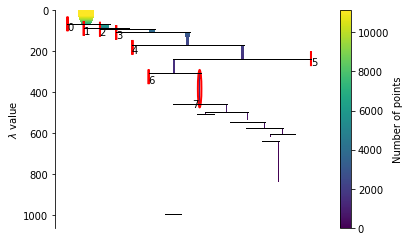

In [36]:
hdbscanner.condensed_tree_.plot(select_clusters=True, label_clusters=True, selection_palette=sns.color_palette('deep', 8));

In [37]:
X_nmf_train.shape

(11124, 10)

Given that we have HDBSCAN labels, what can we do with this considering we're still in 10 dimensional space

In [42]:
cuisine_hdbscan_labels_train = list(zip(y_train, hdbscan_X_train_predicted_labels[0]))

cuisine_hdbscan_labels_train_df = pd.DataFrame(data=hdbscan_X_train_predicted_labels[0], columns=[ 'hdbscan_label'], index=X_nmf_train.index)

cuisine_hdbscan_labels_train_df

,hdbscan_label
id,
54a45bfb6529d92b2c023f25,-1
54a4638719925f464b395c16,-1
54a441126529d92b2c01b5f2,-1
54a409bb19925f464b37380a,-1
54a42e1019925f464b3818d4,-1
...,...
54a436266529d92b2c018767,-1
54a466e16529d92b2c026f67,-1
54a451cd6529d92b2c01eefd,-1


In [43]:
cuisine_hdbscan_labels_test = list(zip(y_test, hdbscan_X_test_labels[0]))
cuisine_hdbscan_labels_test_df = pd.DataFrame(data=hdbscan_X_test_labels[0], columns=['hdbscan_label'], index=X_nmf_test.index)

cuisine_hdbscan_labels_test_df

,hdbscan_label
id,
54a44e9719925f464b38d22d,-1
54a477346529d92b2c02afd0,-1
54a455a219925f464b3916be,0
54a472e26529d92b2c029f24,-1
54a45db36529d92b2c02461b,-1
...,...
54a459976529d92b2c0232a2,-1
54a414416529d92b2c0057b0,-1
54a40b4919925f464b373c4a,-1


In [47]:
joined = 1
joined = pd.concat([recipes_with_cv, cuisine_hdbscan_labels_train_df, cuisine_hdbscan_labels_test_df], axis=1)
joined

,dek,hed,aggregateRating,ingredients,prepSteps,reviewsCount,willMakeAgainPct,cuisine_name,photo_filename,photo_credit,...,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper,hdbscan_label,hdbscan_label
id,,,,,,,,,,,,,,,,,,,,,
54a2b6b019925f464b373351,How does fried chicken achieve No. 1 status? B...,Pickle-Brined Fried Chicken,3.11,"[1 tablespoons yellow mustard seeds, 1 tablesp...",[Toast mustard and coriander seeds in a dry me...,7,100,Missing Cuisine,51247610_fried-chicken_1x1.jpg,Michael Graydon and Nikole Herriott,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
54a408a019925f464b3733bc,Spinaci all'Ebraica,Spinach Jewish Style,3.22,"[3 pounds small-leaved bulk spinach, Salt, 1/2...",[Remove the stems and roots from the spinach. ...,5,80,Italian,EP_12162015_placeholders_rustic.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,NaN
54a408a26529d92b2c003631,"This majestic, moist, and richly spiced honey ...",New Year’s Honey Cake,3.62,"[3 1/2 cups all-purpose flour, 1 tablespoon ba...",[I like this cake best baked in a 9-inch angel...,105,88,Kosher,EP_09022015_honeycake-2.jpg,"Photo by Chelsea Kyle, Food Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,NaN
54a408a66529d92b2c003638,The idea for this sandwich came to me when my ...,The B.L.A.Bagel with Lox and Avocado,4.00,"[1 small ripe avocado, preferably Hass (see No...","[A short time before serving, mash avocado and...",7,100,Kosher,EP_12162015_placeholders_casual.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,NaN
54a408a719925f464b3733cc,"In 1930, Simon Agranat, the chief justice of t...",Shakshuka a la Doktor Shakshuka,2.71,"[2 pounds fresh tomatoes, unpeeled and cut in ...","[1. Place the tomatoes, garlic, salt, paprika,...",7,83,Kosher,EP_12162015_placeholders_formal.jpg,"Photo by Chelsea Kyle, Prop Styling by Rhoda B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541a31bff3052847ae2107,Buttering the bread before you waffle it ensur...,Waffled Ham and Cheese Melt with Maple Butter,0.00,"[1 tablespoon unsalted butter, at room tempera...","[Preheat the waffle iron on low., Spread a thi...",0,0,Missing Cuisine,waffle-ham-and-cheese-melt-062817.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
5954233ad52ca90dc28200e7,"Spread this easy compound butter on waffles, p...",Maple Butter,0.00,"[8 tablespoons (1 stick) salted butter, at roo...",[Combine the ingredients in a medium-size bowl...,0,0,Missing Cuisine,EP_12162015_placeholders_bright.jpg,"Photo by Chelsea Kyle, Prop Styling by Anna St...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
595424c2109c972493636f83,Leftover mac and cheese is not exactly one of ...,Waffled Macaroni and Cheese,0.00,"[3 tablespoons unsalted butter, plus more for ...",[Preheat the oven to 375°F. Butter a 9x5-inch ...,0,0,Missing Cuisine,waffle-mac-n-cheese-062816.jpg,"Photo by Maes Studio, Inc.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


What to do now?

1. Can do another dimension reduction to make a 2D visualization after attaching HDBSCAN labels to the original data

Or

1. See how the HDBSCAN labels "map" to cuisine labels
   1. Go back, reattach index labels to data so that you can compare the original recipes with the HDBSCAN labels
2. Predict HDBSCAN labels for the recipes that are missing cuisines and see where they line up (noise, etc)
   1. But also maybe compared to cuisine labels...depending on how many "noisy" recipes there are, this might not be very productive, but see how this looks
3. Could this new HDBSCAN label used instead of a hard mapped cuisine label? What would the results look like?
   1. Gets a little tricky if recipes map to noise
   2. This involves a refactor of MeaLeon's webapp (which is overdue)
4. Can still do 2D visualization to have something up
   1. Mix in the probability to impact "density" of color (like the HDBSCAN plot examples...but in Bokeh)

In [50]:
combined = pd.concat([cuisine_hdbscan_labels_train_df, cuisine_hdbscan_labels_test_df], axis=0)

joined = pd.concat([reduced_df, combined], axis=1)

In [51]:
joined

,cuisine_name,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,...,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper,hdbscan_label
id,,,,,,,,,,,,,,,,,,,,,
54a408a019925f464b3733bc,Italian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
54a408a26529d92b2c003631,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
54a408a66529d92b2c003638,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
54a408a719925f464b3733cc,Kosher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
54a408c36529d92b2c0036a1,French,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587fabfecd2508314395ad8c,Chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
588a417612082e6b03c03d27,Indian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
58924da769cf1107794eb164,American,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


KeyboardInterrupt: 

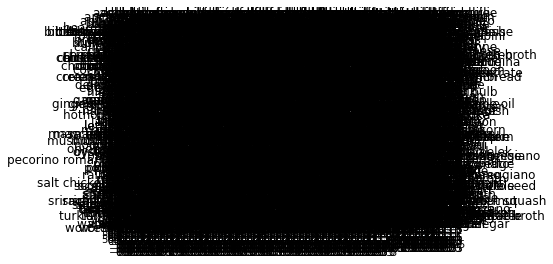

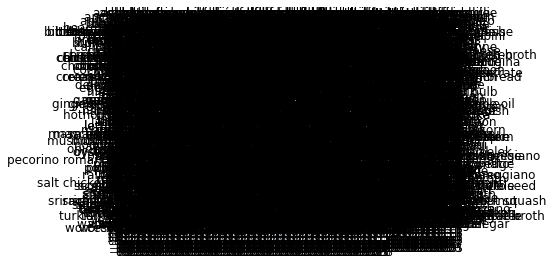

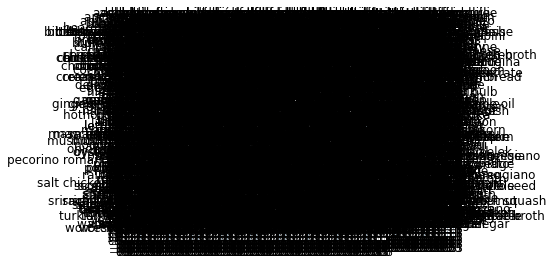

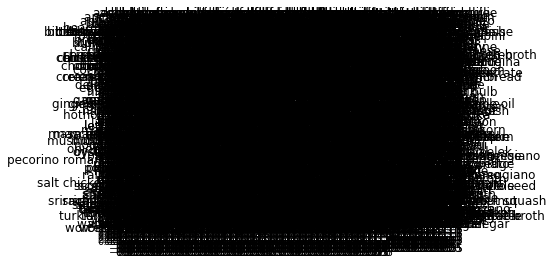

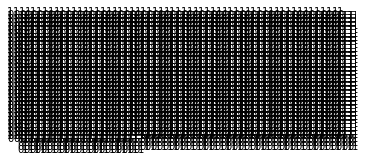

In [52]:
# Group By Cuisine name, and maybe get a histogram of HDBSCAN labels
joined.groupby(['cuisine_name', 'hdbscan_label']).count()

Go back and just use cuisine labels and hdbscan labels (like i had before)

In [54]:
joined_sub_df = joined[['cuisine_name', 'hdbscan_label']]
joined_sub_df

,cuisine_name,hdbscan_label
id,,
54a408a019925f464b3733bc,Italian,-1
54a408a26529d92b2c003631,Kosher,-1
54a408a66529d92b2c003638,Kosher,-1
54a408a719925f464b3733cc,Kosher,-1
54a408c36529d92b2c0036a1,French,7
...,...,...
587fabfecd2508314395ad8c,Chinese,-1
588a417612082e6b03c03d27,Indian,-1
58924da769cf1107794eb164,American,-1


/home/awchen/Repos/Projects/MeaLeon/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


cuisine_name  hdbscan_label
African       -1               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
               2               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
               6               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
               7               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
American      -1               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
                                                 ...                   
Thai           7               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Vietnamese    -1               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
               2               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
               4               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
               7               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Length: 125, dtype: object

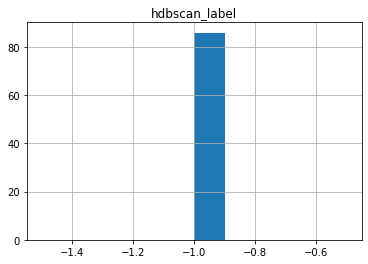

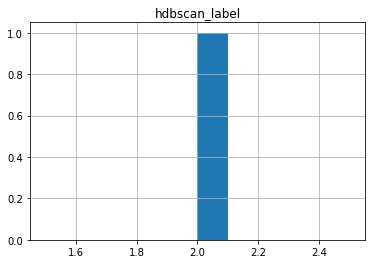

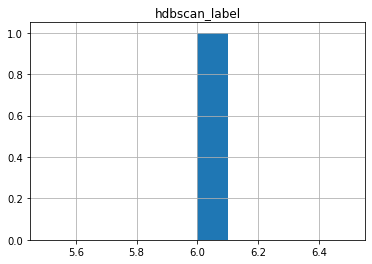

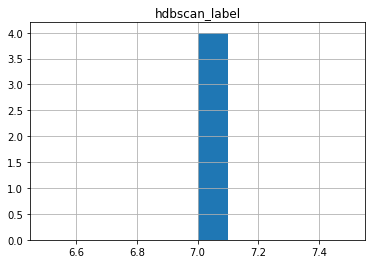

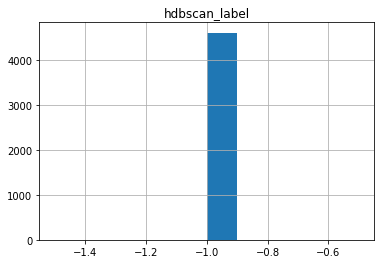

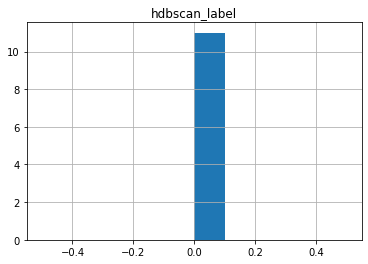

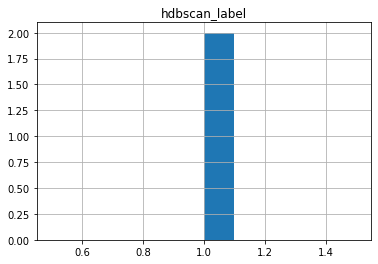

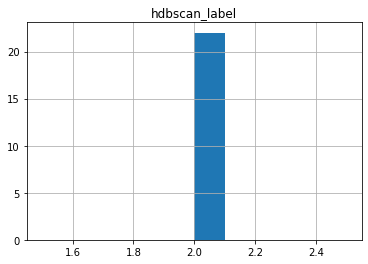

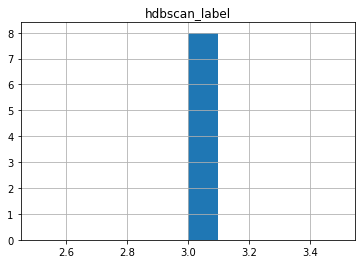

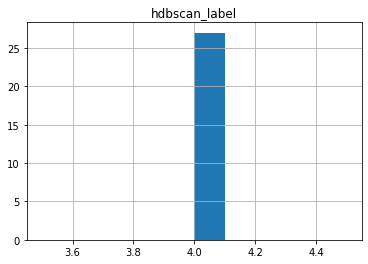

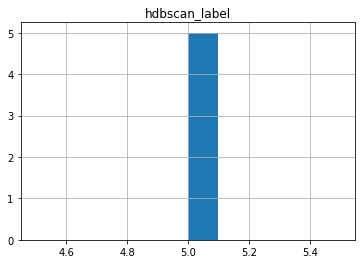

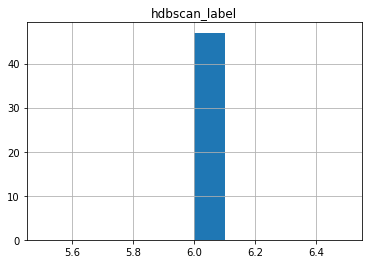

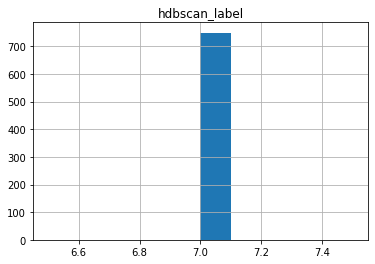

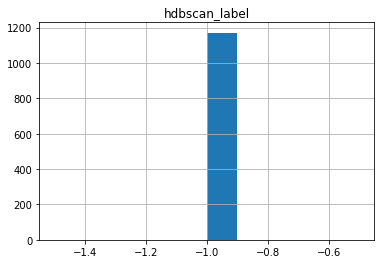

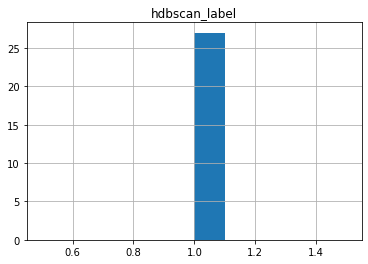

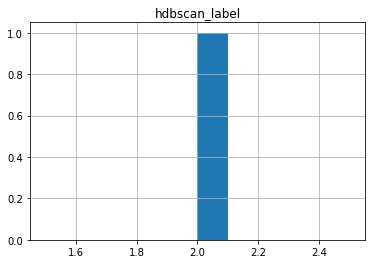

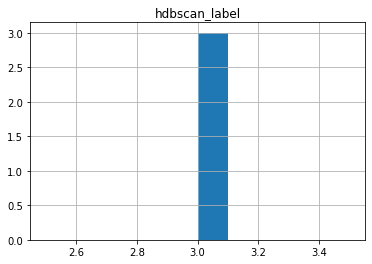

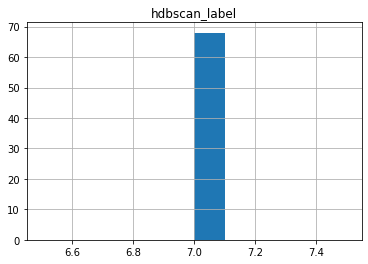

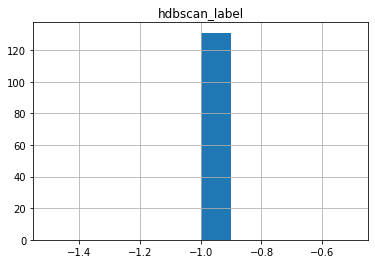

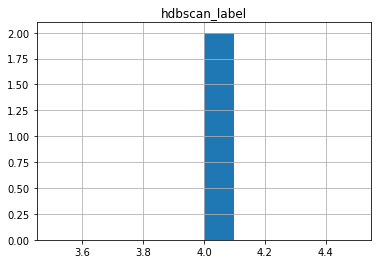

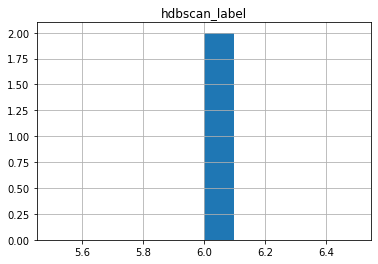

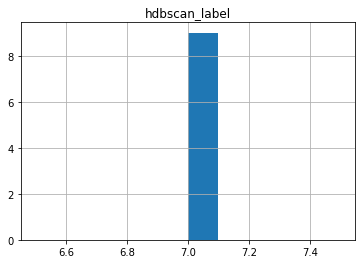

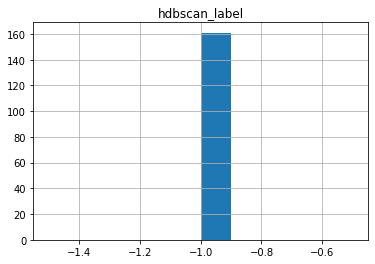

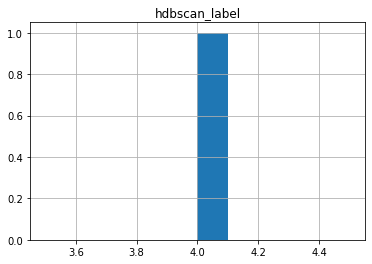

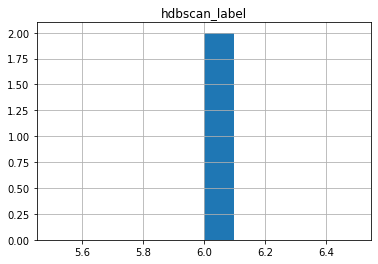

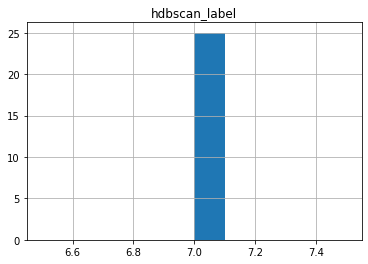

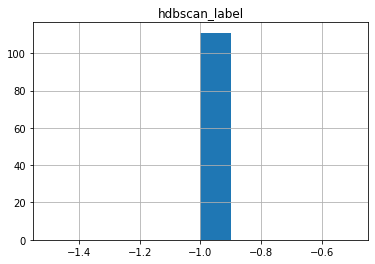

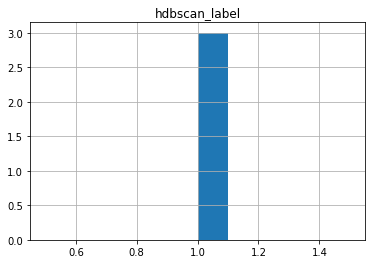

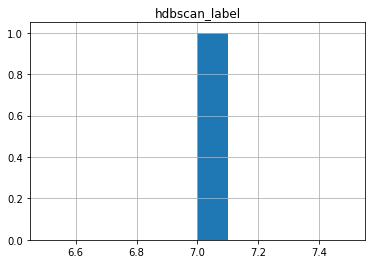

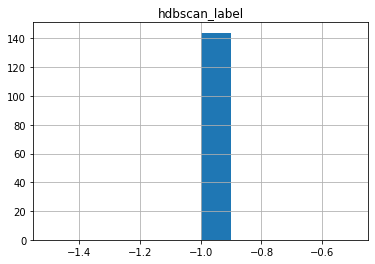

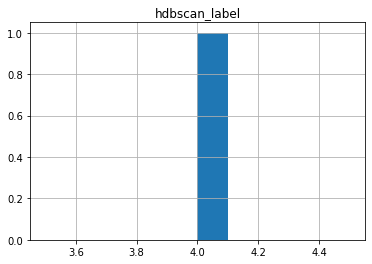

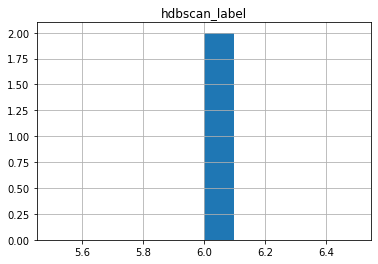

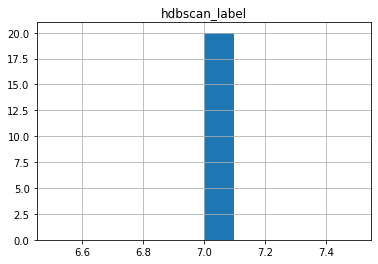

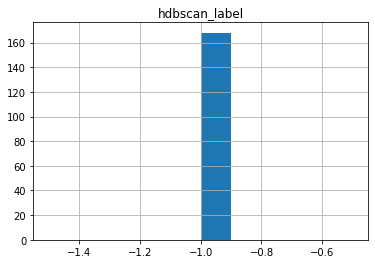

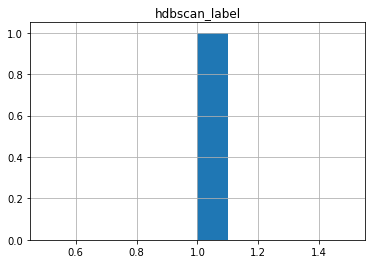

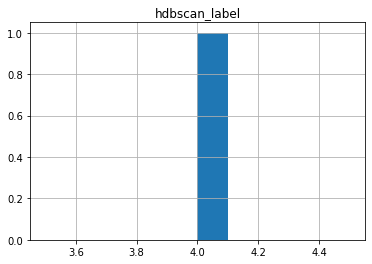

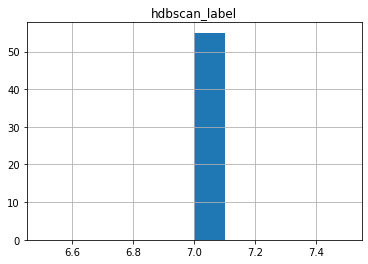

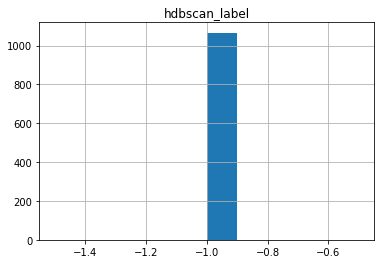

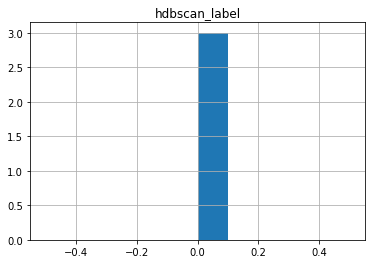

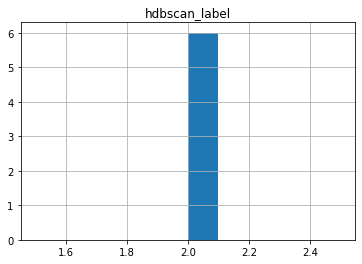

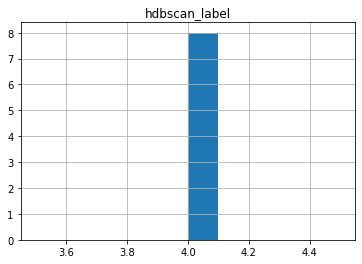

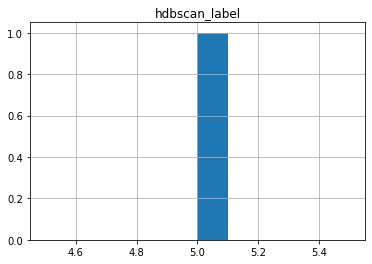

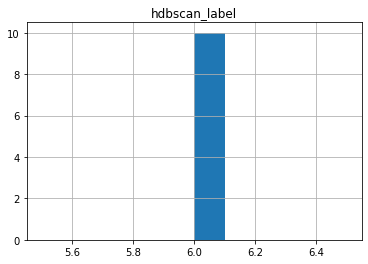

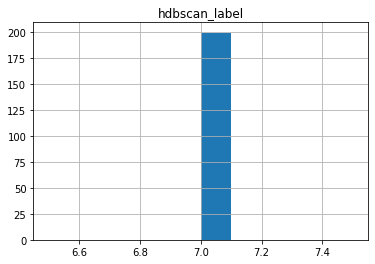

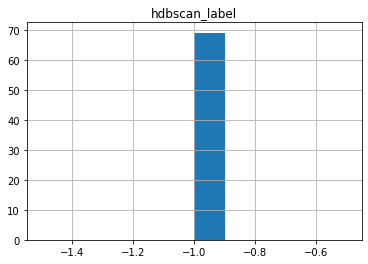

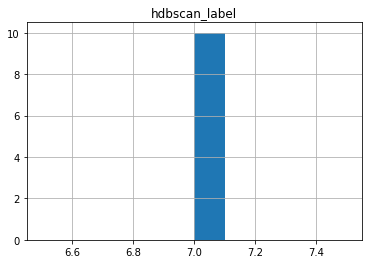

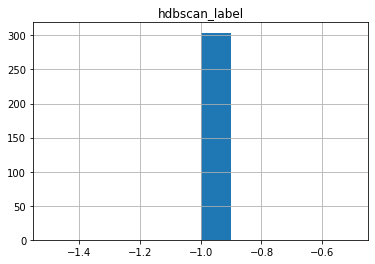

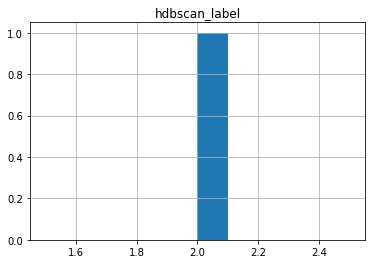

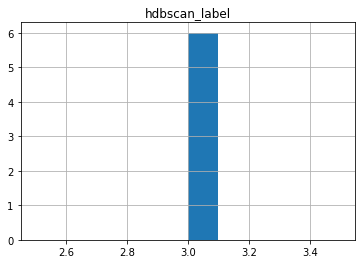

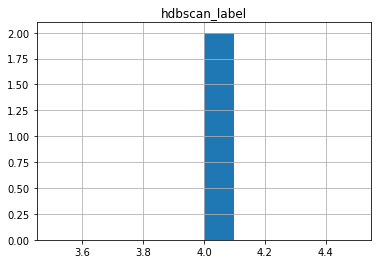

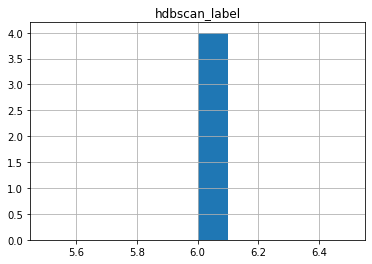

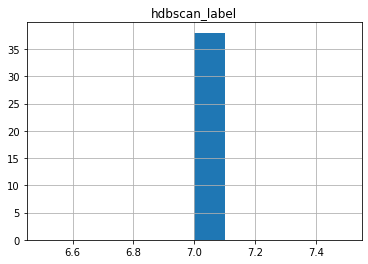

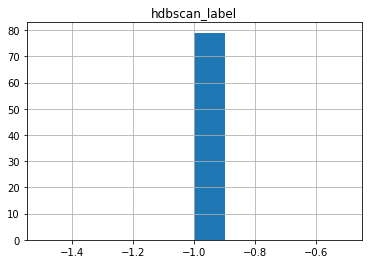

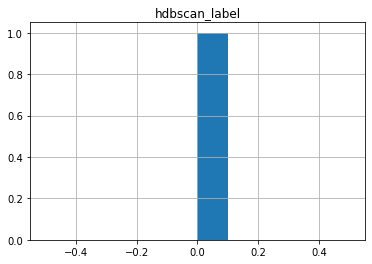

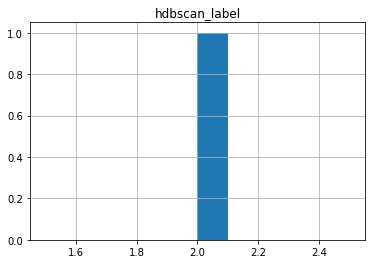

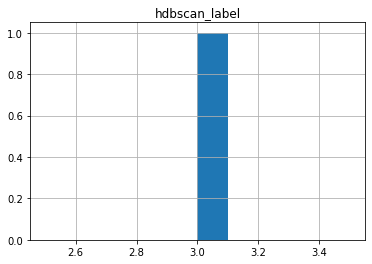

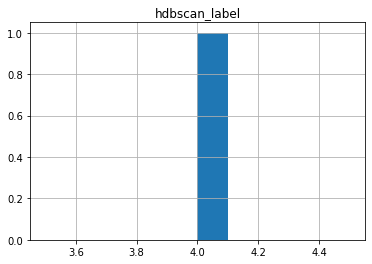

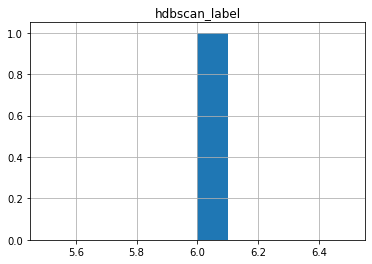

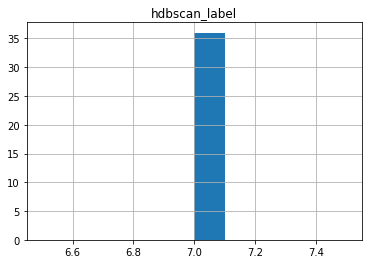

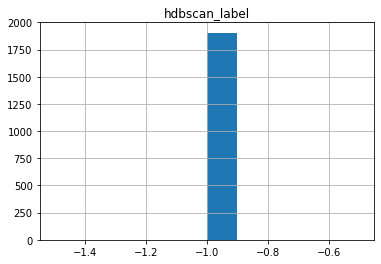

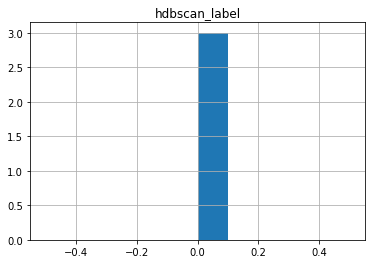

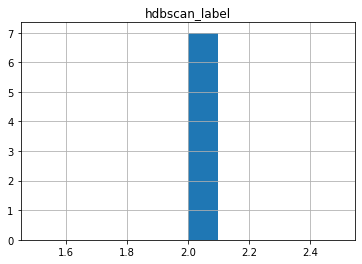

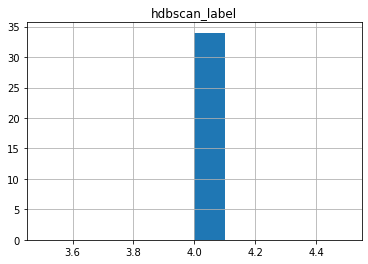

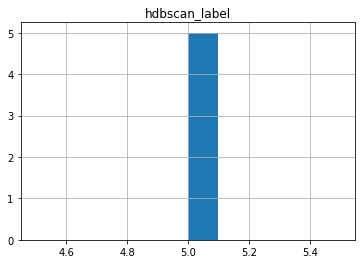

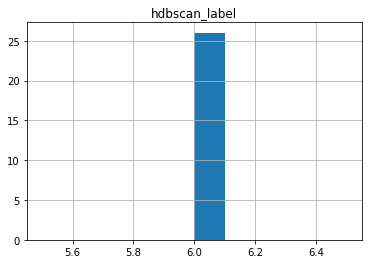

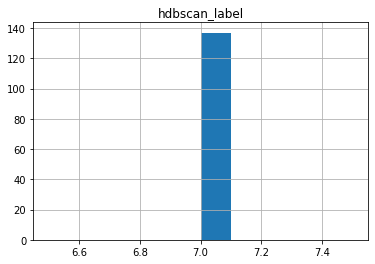

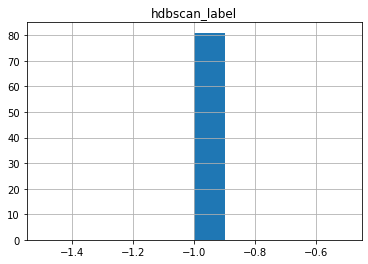

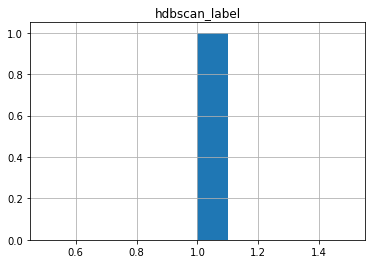

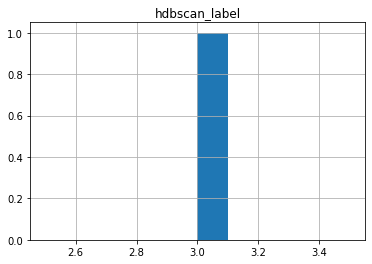

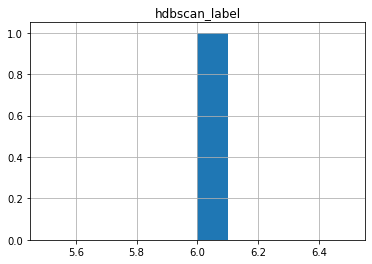

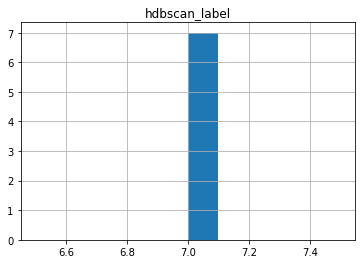

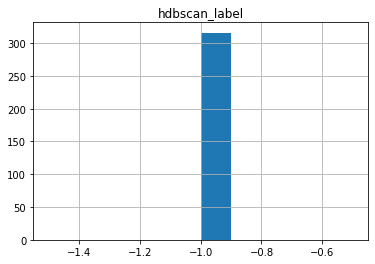

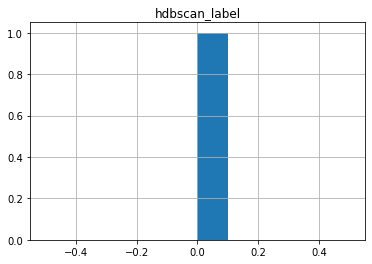

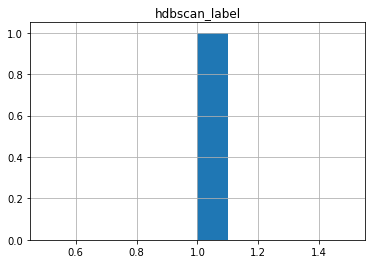

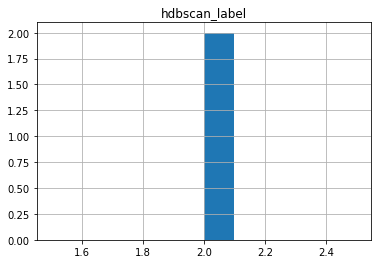

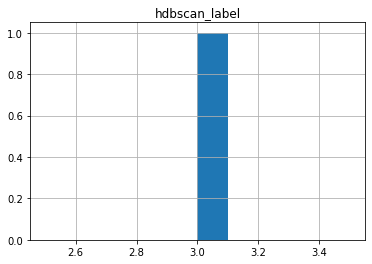

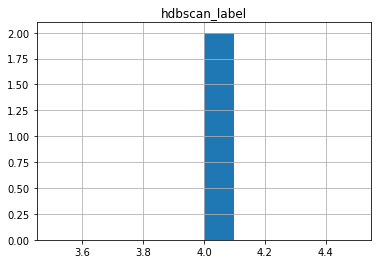

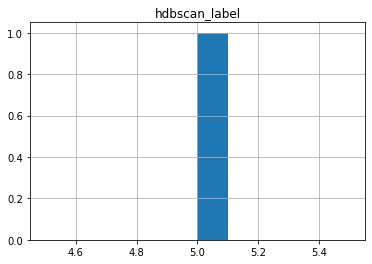

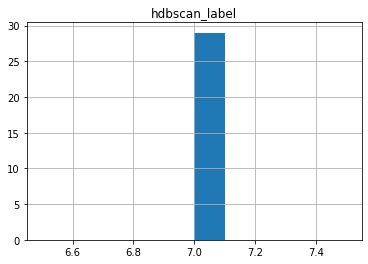

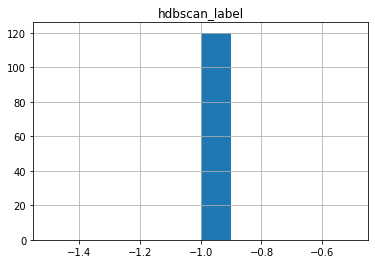

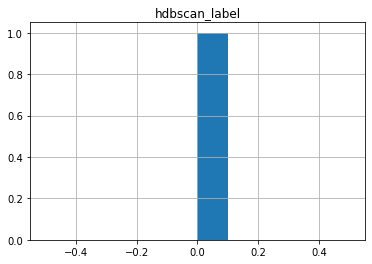

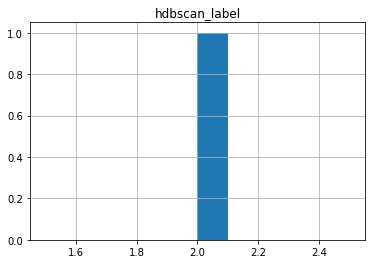

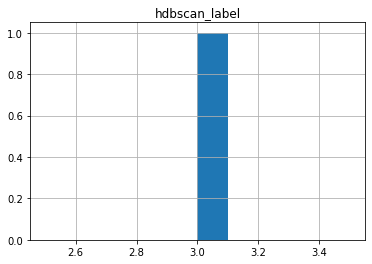

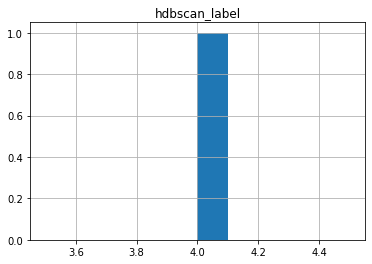

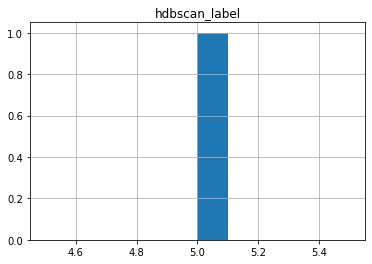

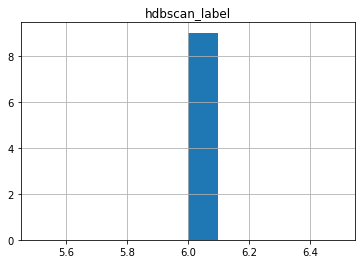

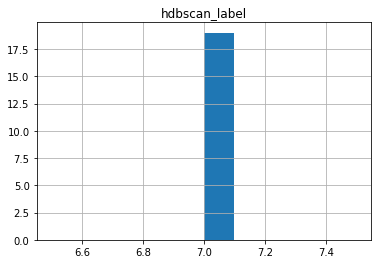

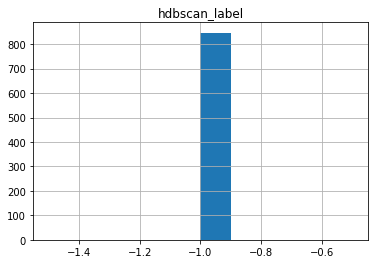

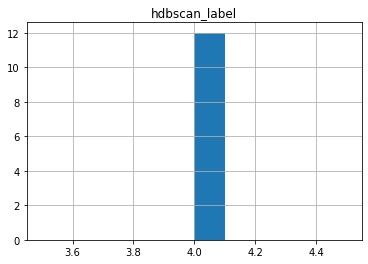

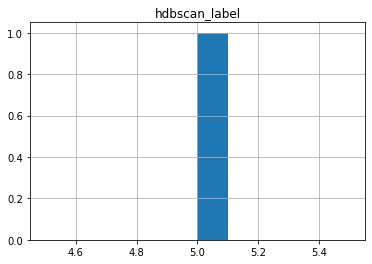

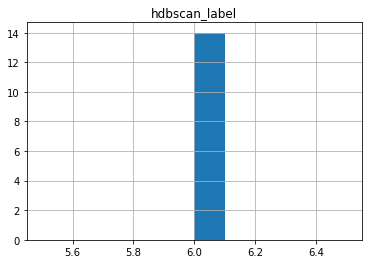

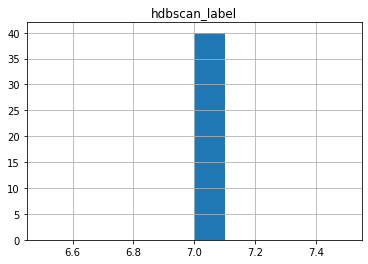

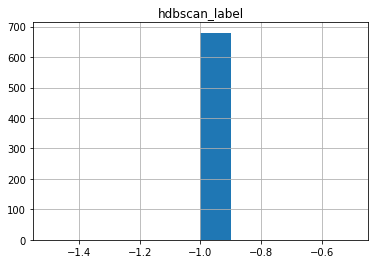

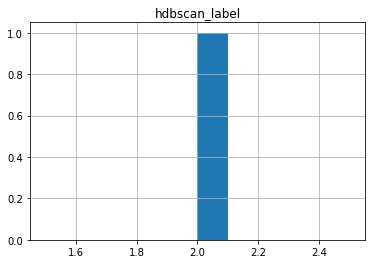

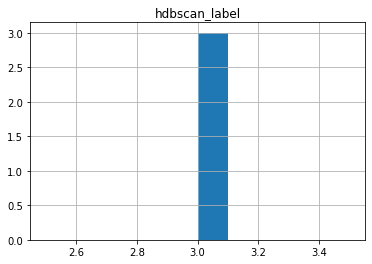

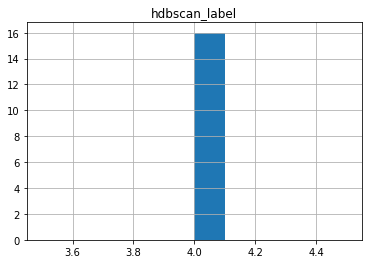

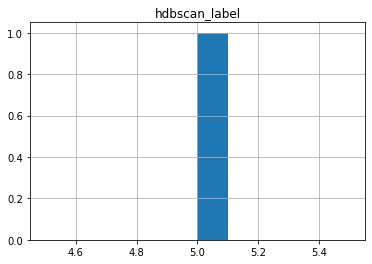

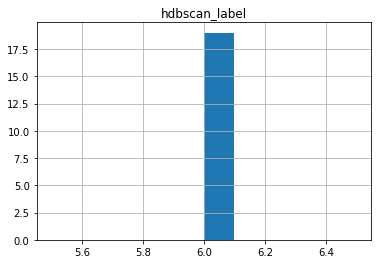

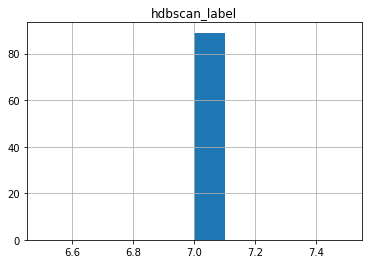

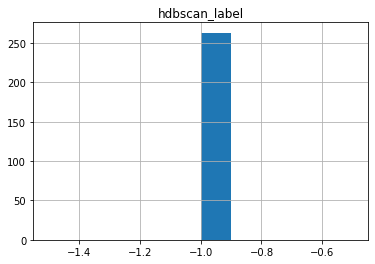

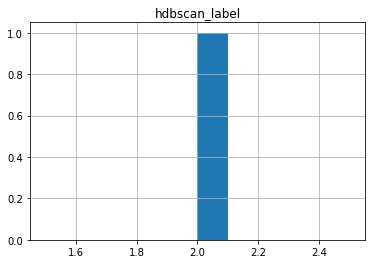

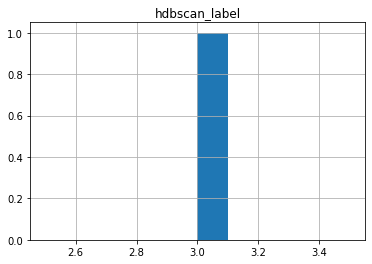

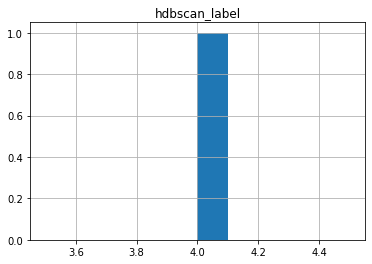

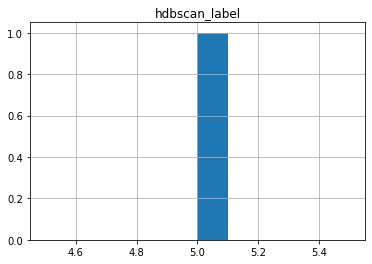

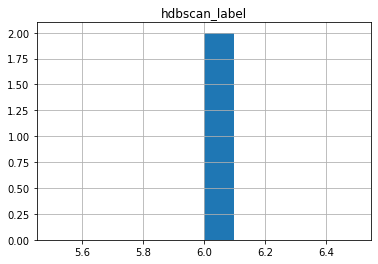

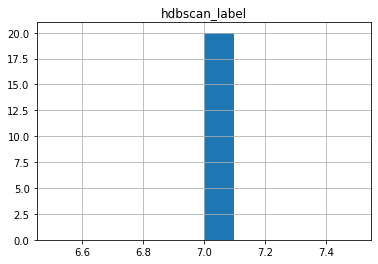

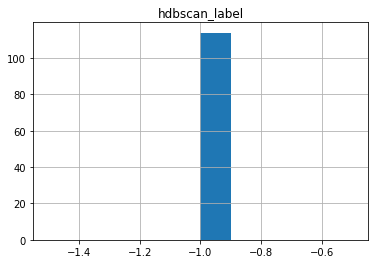

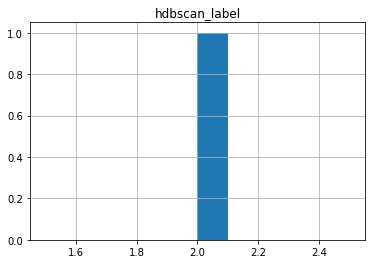

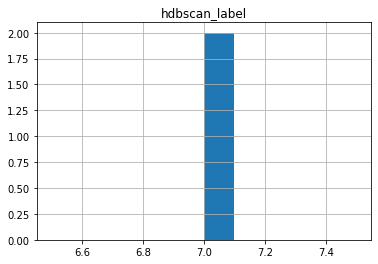

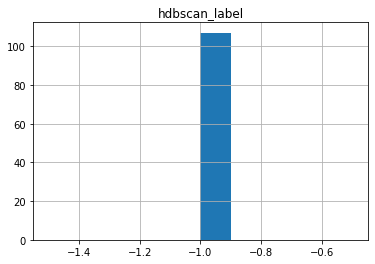

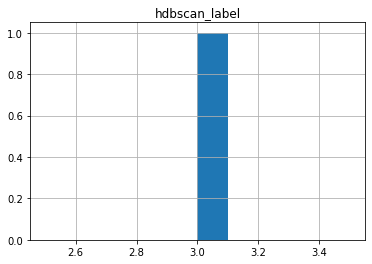

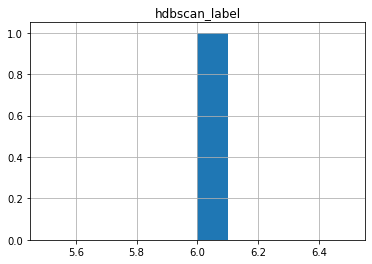

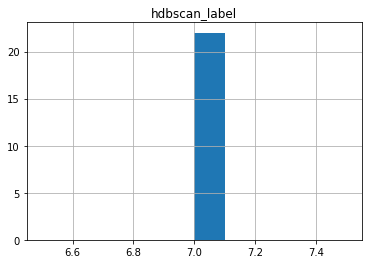

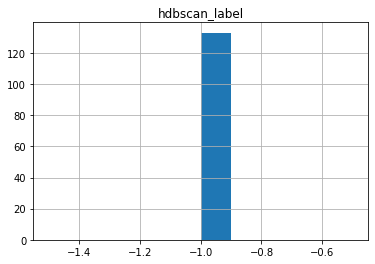

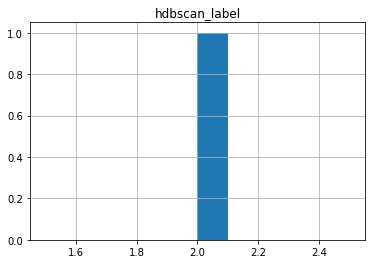

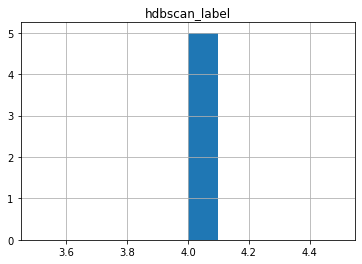

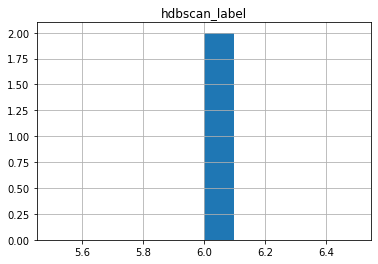

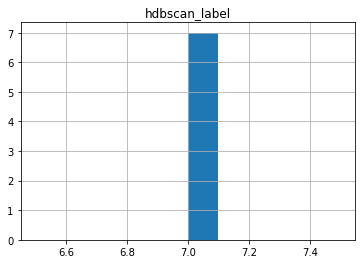

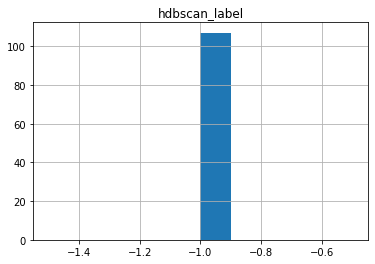

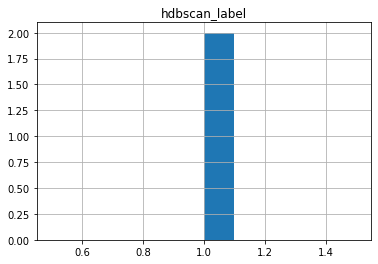

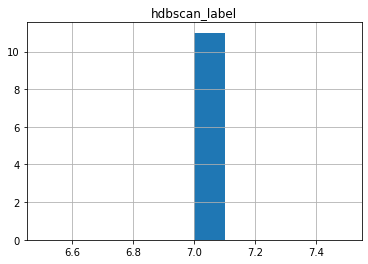

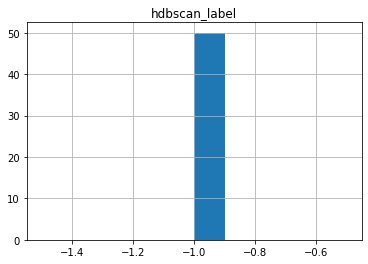

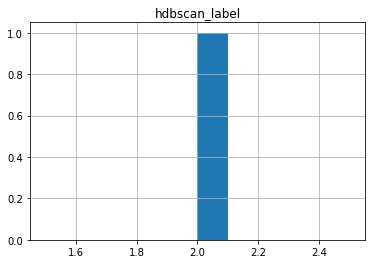

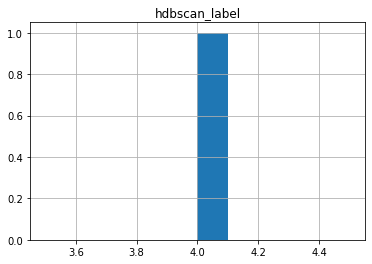

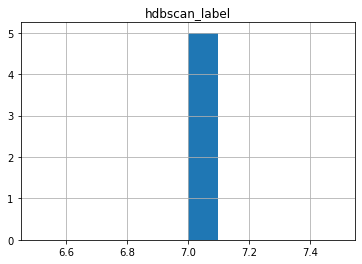

In [59]:
# joined_sub_df.groupby(['cuisine_name', 'hdbscan_label']).hist();

This wasn't the right way...too many plots, and not a lot of sense with them

Let's try a pivot table

In [77]:
joined_groupby = joined_sub_df.groupby(by=['cuisine_name', 'hdbscan_label']).value_counts()

In [93]:
joined_groupby

cuisine_name  hdbscan_label
African       -1                 86
               2                  1
               6                  1
               7                  4
American      -1               4613
                               ... 
Thai           7                 11
Vietnamese    -1                 50
               2                  1
               4                  1
               7                  5
Length: 125, dtype: int64

In [78]:
joined_groupby['American']

hdbscan_label
-1    4613
 0      11
 1       2
 2      22
 3       8
 4      27
 5       5
 6      47
 7     749
dtype: int64

In [82]:
for cuisine in joined_groupby.index:
    print(np.unique(cuisine[0]))

['African']
['African']
['African']
['African']
['American']
['American']
['American']
['American']
['American']
['American']
['American']
['American']
['American']
['Asian']
['Asian']
['Asian']
['Asian']
['Asian']
['Cajun/Creole']
['Cajun/Creole']
['Cajun/Creole']
['Cajun/Creole']
['Caribbean']
['Caribbean']
['Caribbean']
['Caribbean']
['Chinese']
['Chinese']
['Chinese']
['Eastern European']
['Eastern European']
['Eastern European']
['Eastern European']
['English']
['English']
['English']
['English']
['French']
['French']
['French']
['French']
['French']
['French']
['French']
['German']
['German']
['Indian']
['Indian']
['Indian']
['Indian']
['Indian']
['Indian']
['Irish']
['Irish']
['Irish']
['Irish']
['Irish']
['Irish']
['Irish']
['Italian']
['Italian']
['Italian']
['Italian']
['Italian']
['Italian']
['Italian']
['Japanese']
['Japanese']
['Japanese']
['Japanese']
['Japanese']
['Kosher']
['Kosher']
['Kosher']
['Kosher']
['Kosher']
['Kosher']
['Kosher']
['Kosher']
['Latin American']
['

In [88]:
cuisine_names = np.unique(y.values).tolist()
cuisine_names

['African',
 'American',
 'Asian',
 'Cajun/Creole',
 'Caribbean',
 'Chinese',
 'Eastern European',
 'English',
 'French',
 'German',
 'Indian',
 'Irish',
 'Italian',
 'Japanese',
 'Kosher',
 'Latin American',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Moroccan',
 'Scandinavian',
 'Southwestern',
 'Thai',
 'Vietnamese']

In [90]:
for cuisine in cuisine_names:
    print(cuisine, joined_groupby[cuisine])

African hdbscan_label
-1    86
 2     1
 6     1
 7     4
dtype: int64
American hdbscan_label
-1    4613
 0      11
 1       2
 2      22
 3       8
 4      27
 5       5
 6      47
 7     749
dtype: int64
Asian hdbscan_label
-1    1171
 1      27
 2       1
 3       3
 7      68
dtype: int64
Cajun/Creole hdbscan_label
-1    131
 4      2
 6      2
 7      9
dtype: int64
Caribbean hdbscan_label
-1    161
 4      1
 6      2
 7     25
dtype: int64
Chinese hdbscan_label
-1    111
 1      3
 7      1
dtype: int64
Eastern European hdbscan_label
-1    144
 4      1
 6      2
 7     20
dtype: int64
English hdbscan_label
-1    168
 1      1
 4      1
 7     55
dtype: int64
French hdbscan_label
-1    1066
 0       3
 2       6
 4       8
 5       1
 6      10
 7     199
dtype: int64
German hdbscan_label
-1    69
 7    10
dtype: int64
Indian hdbscan_label
-1    304
 2      1
 3      6
 4      2
 6      4
 7     38
dtype: int64
Irish hdbscan_label
-1    79
 0     1
 2     1
 3     1
 4     1
 6 

Ok, we're seeing a lot of noise in each label...how to address?
Eg, African food has 86 out of 92 counting as noise

If we want to use the HDBSCAN clustering, how can we determine a cluster if so many of the recipes are just noise.

According to [documentation](https://hdbscan.readthedocs.io/en/latest/faq.html):

Q: Most of data is classified as noise; why?

The amount of data classified as noise is controlled by the min_samples parameter. By default, if not otherwise set, this value is set to the same value as min_cluster_size. You can set it independently if you wish by specifying it separately. The lower the value, the less noise you’ll get, but there are limits, and it is possible that you simply have noisy data. See _min_samples_label for more details.

Optuna decided on: 
'min_cluster_size': 14,
'min_samples': 57,

Thinking on this: there are pretty under represented cuisines, which is fine, because we're not expecting HDBSCAN to perfectly overlap with the cuisine flags, however, there is concern if it keeps hitting noise...maybe just get the next highest probability cluster label and use that

In [94]:
joined_groupby['Thai']

hdbscan_label
-1    107
 1      2
 7     11
dtype: int64

In [95]:
training_set_hdbscan_probabilities = hdbscan.prediction.all_points_membership_vectors(hdbscanner)
training_set_hdbscan_probabilities

array([[0.04762073, 0.06359475, 0.08723512, ..., 0.10575208, 0.13994041,
        0.1318328 ],
       [0.3887856 , 0.06480752, 0.06796418, ..., 0.06799384, 0.07048889,
        0.07476461],
       [0.05324901, 0.0641129 , 0.0809652 , ..., 0.08740883, 0.10388981,
        0.10318631],
       ...,
       [0.05019189, 0.05507058, 0.15954458, ..., 0.0644048 , 0.06759725,
        0.06680872],
       [0.03383916, 0.02673606, 0.03021665, ..., 0.03386854, 0.04022896,
        0.53663445],
       [0.09091266, 0.07980986, 0.08949809, ..., 0.08758645, 0.09540361,
        0.31866998]])

In [96]:
# for each record, we want to go into the array, grab the top two values (probabilities), and use the index as the HDBSCAN label, then put in another list as things to exclude

training_set_hdbscan_probabilities[0]

array([0.04762073, 0.06359475, 0.08723512, 0.12125164, 0.25125773,
       0.10575208, 0.13994041, 0.1318328 ])

In [99]:
np.argpartition(training_set_hdbscan_probabilities[0], -2)[-2:]

array([6, 4])

In [118]:
func = lambda x: np.argpartition(x, -2)[-2:]

train_high_val_hdbscan_labels = np.array(list(map(func, training_set_hdbscan_probabilities)))
train_high_val_hdbscan_labels

array([[6, 4],
       [7, 0],
       [4, 3],
       ...,
       [3, 2],
       [6, 7],
       [3, 7]])

In [119]:
train_high_val_hdbscan_labels.shape

(11124, 2)

In [108]:
# the code cell above gives us the top two hdbscan labels for each recipe
test_proba = hdbscan.prediction.membership_vector(hdbscanner, X_nmf_test)
test_hign_val_hdbscan_labels = np.array(list(map(func, test_proba)))
test_hign_val_hdbscan_labels

TypeError: Argument 'point' has incorrect type (expected numpy.ndarray, got Series)

In [109]:
X_nmf_test

,0,1,2,3,4,5,6,7,8,9
id,,,,,,,,,,
54a44e9719925f464b38d22d,0.009966,0.004701,0.000000,0.001613,0.000000,0.0,0.000000,0.000000,0.003761,0.000000
54a477346529d92b2c02afd0,0.026861,0.009604,0.000000,0.000000,0.000000,0.0,0.013537,0.000000,0.000000,0.000000
54a455a219925f464b3916be,0.000000,0.028052,0.000000,0.000000,0.000000,0.0,0.000000,0.057746,0.000000,0.000000
54a472e26529d92b2c029f24,0.001359,0.000000,0.000000,0.037131,0.000000,0.0,0.000000,0.000000,0.013778,0.000000
54a45db36529d92b2c02461b,0.030422,0.003601,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.036672,0.020256
...,...,...,...,...,...,...,...,...,...,...
54a459976529d92b2c0232a2,0.004975,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.011115,0.000000
54a414416529d92b2c0057b0,0.027230,0.000000,0.000000,0.000000,0.025985,0.0,0.016946,0.000000,0.000000,0.000000
54a40b4919925f464b373c4a,0.018970,0.000000,0.000000,0.075925,0.019974,0.0,0.000000,0.000000,0.004928,0.012472


In [110]:
X_nmf_train

,0,1,2,3,4,5,6,7,8,9
id,,,,,,,,,,
54a45bfb6529d92b2c023f25,0.011332,0.000000,0.000000,0.000000,0.024039,0.000000,0.000000,0.000000,0.005670,0.000000
54a4638719925f464b395c16,0.002359,0.030674,0.000000,0.000000,0.000000,0.000000,0.000000,0.093221,0.000000,0.000000
54a441126529d92b2c01b5f2,0.009284,0.000000,0.000000,0.000000,0.021213,0.027354,0.000000,0.000000,0.000000,0.000000
54a409bb19925f464b37380a,0.018171,0.009565,0.000000,0.076212,0.000000,0.000000,0.000000,0.000000,0.009926,0.000000
54a42e1019925f464b3818d4,0.024393,0.005658,0.019932,0.000000,0.005299,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
54a436266529d92b2c018767,0.000000,0.034086,0.000000,0.000000,0.000000,0.024287,0.031245,0.000000,0.000000,0.000000
54a466e16529d92b2c026f67,0.013393,0.000000,0.000000,0.000000,0.000000,0.006999,0.021508,0.000000,0.004949,0.000000
54a451cd6529d92b2c01eefd,0.011930,0.000000,0.000000,0.058731,0.000000,0.026735,0.000000,0.000000,0.000000,0.000000


In [111]:
X_nmf_test.values

array([[0.00996642, 0.00470136, 0.        , ..., 0.        , 0.00376106,
        0.        ],
       [0.0268609 , 0.00960397, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02805185, 0.        , ..., 0.05774607, 0.        ,
        0.        ],
       ...,
       [0.01897009, 0.        , 0.        , ..., 0.        , 0.00492834,
        0.01247162],
       [0.00745672, 0.01665624, 0.00371109, ..., 0.        , 0.        ,
        0.        ],
       [0.05360218, 0.00408501, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [120]:
test_proba = hdbscan.prediction.membership_vector(hdbscanner, X_nmf_test.values)
test_hign_val_hdbscan_labels = np.array(list(map(func, test_proba)))
test_hign_val_hdbscan_labels

array([[7, 6],
       [6, 1],
       [3, 7],
       ...,
       [4, 2],
       [6, 7],
       [5, 4]])

In [113]:
test_hign_val_hdbscan_labels.shape

(3708, 2)

In [ ]:
# I can re attach the recipe IDs to train and test arrays, then combine in a pd.DataFrame if wanted

In [115]:
nmf

array([[0.03752204, 0.00213006, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0497261 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02012581, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01340822],
       ...,
       [0.00720787, 0.00187156, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01290498, 0.        , 0.01672848, ..., 0.        , 0.        ,
        0.01041413],
       [0.        , 0.00161197, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [121]:
nmf_path = joblib_basepath + 'nmf.joblib' #nmf
X_nmf_path = joblib_basepath + 'X_nmf.joblib' #X_nmf

hdbscan_model_path = joblib_basepath + 'hdbscan.joblib' #hdbscanner
train_high_val_hdbscan_labels_path = joblib_basepath + 'train_high_val_hdbscan.joblib' #train_high_val_hdbscan_labels
test_high_val_hdbscan_labels_path = joblib_basepath + 'test_high_val_hdbscan.joblib' #test_high_val_hdbscan_labels

dump(nmf, nmf_path)
dump(X_nmf, X_nmf_path)
dump(hdbscanner, hdbscan_model_path)
dump(train_high_val_hdbscan_labels, train_high_val_hdbscan_labels_path)
dump(test_hign_val_hdbscan_labels, test_high_val_hdbscan_labels_path)

['../../joblib/2022.08.23/test_high_val_hdbscan.joblib']

In [ ]:
wcss = []
for i in range(2, 32):
    clustering = KMeans(n_clusters=i, random_state=200)
    clustering.fit(X_train_transformed)
    wcss.append(clustering.inertia_)

ks = list(range(2,32))
sns.lineplot(x = ks, y = wcss);

This looks like 5 clusters on 5 features

In [ ]:
for i in range(2, 23):

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    # ax1.set_ylim([0, len(to_plot_tsne) + (i + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=i, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(
        "For n_clusters =",
        i,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    # ax2.scatter(
    #     to_plot_tsne['x'], to_plot_tsne['y'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    # )

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for k, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % k, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
